# 5. 文本聚类和主题模型

## 文本聚类：
- 核心思想：
  - 把“相似的文本”分到同一组
  - 算法不会告诉你这个类别叫什么，只是把相似的放在一起
- 常见方法：
  - k-means、DBscan
  - 先embedding，然后计算相似度
## 文本模型
- 核心思想：
  - 自动找出“文本集合中隐藏的主题结构”
  - 不是简单的分组，而是：
    - 每个主题 = 一组高频关键词
    - 每篇文章 = 多个主题的混合
- 常见方法：
  - LDA
  - pLSA
  - NMF
## 核心区别
| 对比点         | 文本聚类     | 主题模型               |
| ----------- | -------- | ------------------ |
| 目标          | 把相似文本分组  | 找出隐藏主题结构           |
| 输出          | 每条文本一个类别 | 每个主题一组关键词 + 文本主题分布 |
| 文本是否可属于多个主题 | ❌ 只能一个类  | ✅ 可以多个主题           |
| 是否有可解释关键词   | ❌ 没有     | ✅ 有                |
| 数学本质        | 距离/密度分组  | 概率生成模型             |


In [1]:
import  os
os.environ["HF_HOME"] = "/openbayes/home/huggingface"
os.environ["HF_DATASETS_OFFLINE"] = "0"
os.environ["TRANSFORMERS_OFFLINE"] = "0"

## 5.1 加载数据, ArXiv 文章: Computation and Language


In [2]:
# 加载
from datasets import load_dataset
dataset = load_dataset("maartengr/arxiv_nlp")["train"]

# 查看metadata数据
abstracts = dataset["Abstracts"]
titles = dataset["Titles"]

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


README.md:   0%|          | 0.00/617 [00:00<?, ?B/s]

data.csv:   0%|          | 0.00/53.2M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [3]:
dataset

Dataset({
    features: ['Titles', 'Abstracts', 'Years', 'Categories'],
    num_rows: 44949
})

num_rows: 44949表示总共有44949篇论文
Titles表示论文标题
Abstracts表示论文摘要
Years表示发表年份
Categories表示arXiv分类标签

In [4]:
titles[:1]

['Introduction to Arabic Speech Recognition Using CMUSphinx System']

In [5]:
abstracts[:1]


['  In this paper Arabic was investigated from the speech recognition problem\npoint of view. We propose a novel approach to build an Arabic Automated Speech\nRecognition System (ASR). This system is based on the open source CMU Sphinx-4,\nfrom the Carnegie Mellon University. CMU Sphinx is a large-vocabulary;\nspeaker-independent, continuous speech recognition system based on discrete\nHidden Markov Models (HMMs). We build a model using utilities from the\nOpenSource CMU Sphinx. We will demonstrate the possible adaptability of this\nsystem to Arabic voice recognition.\n']

## 5.2 文本聚类流程
### 5.2.1 文本表示

In [6]:
from sentence_transformers import SentenceTransformer # 这是一个专门把文本变成向量的工具包

embedding_model = SentenceTransformer('thenlper/gte-small') # 从Hugging face下载并加载一个模型，这个模型可以把文本变成向量

embeddings = embedding_model.encode(abstracts, show_progress_bar=True) # 把所有摘要变成向量

modules.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/583 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/66.7M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/1405 [00:00<?, ?it/s]

In [7]:
# 检查 embedding 的维度
embeddings.shape

(44949, 384)

### 5.2.2 文本降维

In [8]:
from umap import UMAP # umap是一种非线性降维算法

# 将输入的embeddings从384维降到5维
umap_model = UMAP(
    n_components=5, # 目标维度
    min_dist=0.0,   # 控制点之间的最小距离，0表示可以重叠，1表示完全分开；值越小相似论文挤得更紧，聚类结构更明显
    metric='cosine',# 使用余弦相似度来衡量距离
    random_state=42 # 设置随机种子以确保结果可重复
)

In [9]:
reduced_embeddings = umap_model.fit_transform(embeddings)


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [10]:
reduced_embeddings.shape


(44949, 5)

## 5.2.3 根据降维后的embedding进行聚类

In [ ]:
from hdbscan import HDBSCAN # bdbscan是一个基于密度的聚类算法

hdbscan_model = HDBSCAN(
    min_cluster_size = 50,#值越大，簇越稳定、更少；值越小，簇更多、更细碎
    metric = 'euclidean', # 距离度量方式，此处使用的是欧几里得距离
    cluster_selection_method = 'eom' #簇选择策略（核心参数），eom表示从层次密度树中选出 最稳定、最“密”的簇
).fit(reduced_embeddings)
clusters = hdbscan_model.labels_ # 获取每个样本的簇标签

len(set(clusters))

159

In [19]:
clusters

array([143, 143,  -1, ...,  -1, 146,  -1])

## 5.2.4检查聚类结果
手动检查cluster 0中的前三个文档

In [ ]:
import numpy as np

# 打印 cluster 0 中的前三个文档
cluster = 0
for index in np.where(clusters==cluster)[0][:3]:
    print(abstracts[int(index)][:300] + "... \n") # HuggingFace datasets 不接受 numpy.int64 作为索引，只接受原生 int

  This works aims to design a statistical machine translation from English text
to American Sign Language (ASL). The system is based on Moses tool with some
modifications and the results are synthesized through a 3D avatar for
interpretation. First, we translate the input text to gloss, a written fo... 

  Researches on signed languages still strongly dissociate lin- guistic issues
related on phonological and phonetic aspects, and gesture studies for
recognition and synthesis purposes. This paper focuses on the imbrication of
motion and meaning for the analysis, synthesis and evaluation of sign lang... 

  Modern computational linguistic software cannot produce important aspects of
sign language translation. Using some researches we deduce that the majority of
automatic sign language translation systems ignore many aspects when they
generate animation; therefore the interpretation lost the truth inf... 



## 5.2.5 静态绘图


In [21]:
import pandas as pd

# 使用umap将emdeddings降维到2维
reduced_embeddings = UMAP(
    n_components = 2,
    min_dist = 0.0,
    metric = 'cosine',
    random_state = 42
).fit_transform(embeddings)

df = pd.DataFrame(reduced_embeddings,columns=["x","y"])

df["title"] = titles
df['cluster'] = [str(c) for c in clusters]

clusters_df = df.loc[df.cluster != "-1",:] # 只要df.cluster != "-1"的那些行，列都要
outliers_df = df.loc[df.cluster == "-1", :]


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


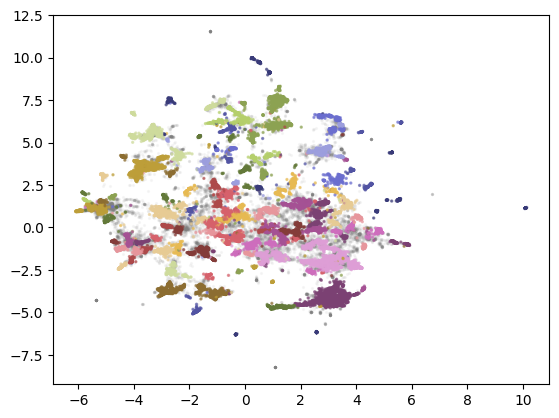

In [22]:
import matplotlib.pyplot as plt

# 分别绘制离群点和非离群点
# 解释：alpha 是透明度，s 是点的大小，cmap 是颜色图
plt.scatter(outliers_df.x, outliers_df.y, alpha=0.05, s=2, c="grey")
plt.scatter(
    clusters_df.x, clusters_df.y, c=clusters_df.cluster.astype(int),
    alpha=0.6, s=2, cmap='tab20b'
)

# 5.3 从文本聚类到主题建模
## 5.3.1 BERTopic: 一个模块化的主题建模框架